# ModelClimateScenarios

We want to understand the potential climatic envelopes for where big trees may occur in the Sierra Nevada ecoregion under future climatic conditions, identifying climatically-stable regions that might become priority conservation areas.

To do this, we'll use recent historic climate data to construct habitat suitability models with presence-background statistical methods (using `elapid`, a python implementation of Maxent). The inputs will be:

- high resolution tree height data, which map the location of trees (veg >= 5m tall) and big trees (veg >=the 95th percentile of height values)
- climate normals from recent/current epochs (1990-2005, 2006-2025) for model training, and two RCP scenarios for conditions in 2026-2045 (RCP 4.5, 8.5)
- maps of vegetation type to qualify the definition of what constitutes a "big" tree in different communities
- disturbance maps—management and wildfire disturbances—to adjust for background sampling bias
    - big trees are less likely to occur in areas that were recently harvested, for example, but that doesn't mean those areas aren't climatically suitable for big trees.

We'll do this in a few steps:

1. generate a large uniform point sample across the ecoregion & extract raster values from each point location
1. quantify sample bias based on time since disturbance & sub-sample using the bias map as our probability distribution
1. split the data into presence (big trees) and background (all trees) data and train models with 5-fold cross validation to quantify uncertainty
1. use the 5-fold models as an ensemble to apply predictions across each climate epoch

Steps 3 & 4 will be done twice: on an ecoregion-basis and on a community type-basis.

## Section 1: Packages, paths & parameters

In [1]:
# imports
from os.path import join
import numpy as np
import artlo
from artlo import plt
import pandas as pd
import rasterio as rio
import geopandas as gpd
import elapid as ela
from sklearn import metrics, model_selection

In [2]:
# paths
bigtrees = '/home/cba/src/cfo-big-trees'
data = join(bigtrees, 'data')
raster = join(data, 'raster')
vector = join(data, 'vector')
models = join(data, 'models')
plots = join(bigtrees, 'docs', 'img')
mask = join(raster, 'SierraEcoregion-Data-Mask-2020-Summer-00010m.tif')
sierra = join(vector, "sierra-ecoregion.gpkg")
canopyHeight = join(raster, "SierraEcoregion-Vegetation-CanopyHeight-2020-Summer-00010m.tif")
vegClasses = join(raster, "SierraEcoregion-Vegetation-Classes-2020-Summer-00030m-cog.tif")
disturbanceMgmt = join(raster, 'SierraEcoregion-Disturbance-Management-2020-Summer-00030m.tif')
disturbanceFire = join(raster, 'SierraEcoregion-Disturbance-TimeSinceFire-2020-Summer-00030m.tif')
climateVars = ['humid', 'ppt', 'rad', 'tmax', 'tmin']
climate1990 = [join(raster, 'climate_normals_utm', 'historical_1990_2005', f"{var}.tif") for var in climateVars]
climate2006 = [join(raster, 'climate_normals_utm', 'rcp45_2006_2025', f"{var}.tif") for var in climateVars]
climatercp45 = [join(raster, 'climate_normals_utm', 'rcp45_2026_2045', f"{var}.tif") for var in climateVars]
climatercp85 = [join(raster, 'climate_normals_utm', 'rcp85_2026_2045', f"{var}.tif") for var in climateVars]

In [3]:
# parameters
n_total_samples = 1_000_000
n_sub_samples = 300_000 # with ~60% tree cover, we expect ~180,000 tree samples, and ~9000 big trees (95%ile)
n_folds = 5
tree_thresh = 5 # UN FAO definition for a tree
big_thresh = 30 # 95th precentile based on prior analysis
artlo.plot.set_style('salo-light')

## Section 2: Sample generation and raster value extraction

In [ ]:
# sample generation
reload = True
points_path = join(models, 'all_points.gpkg')

if reload:
    all_points = gpd.read_file(points_path)
    
else:
    all_points = ela.sample_vector(sierra, n_total_samples)
    gpd.GeoDataFrame(geometry=all_points, crs=all_points.crs).to_file(points_path, driver='GPKG')

In [ ]:
# raster value extraction
reload = True
annotated_path = join(models, 'all_annotated.gpkg')

if reload:
    annotated = gpd.read_file(annotated_path)

else:
    # split the points into two sets of samples and get half the climate data from historic, half from current
    split = n_total_samples // 2
    all_points_1 = all_points[:split]
    all_points_2 = all_points[split:]
    rasters_1 = [canopyHeight, vegClasses, disturbanceMgmt, disturbanceFire, *climate1990]
    rasters_2 = [canopyHeight, vegClasses, disturbanceMgmt, disturbanceFire, *climate2006]
    labels = ["canopyHeight", "vegClass", "distMgmt", "distFire", *climateVars]
    annotated_1 = ela.annotate(all_points_1, rasters_1, labels=labels)
    annotated_2 = ela.annotate(all_points_2, rasters_2, labels=labels)
    annotated = gpd.GeoDataFrame(pd.concat([annotated_1, annotated_2], ignore_index=True))

    # handle invalid data
    valid_height = annotated['canopyHeight'] != -9999
    valid_class = annotated["vegClass"] != 255
    valid_mgmt = annotated["distMgmt"] != 255
    valid_fire = annotated['distFire'] != 255
    valid = valid_height * valid_class * valid_mgmt * valid_fire
    annotated = annotated[valid].reset_index(drop=True)

    # save it
    annotated.to_file(annotated_path, driver='GPKG')

In [ ]:
#annotated['tmax'] -= 273.15
annotated['tmin'] -= 273.15
sampled['tmax'] -= 273.15
sampled['tmin'] -= 273.15

sampled.to_file(sampled_path, driver='GPKG')
annotated.to_file(annotated_path, driver='GPKG')

## Section 3: Quantifying sample bias

### 3.1 Ecoregional sample bias

In [4]:
reload = True
sampled_path = join(models, 'sampled.gpkg')
bias_model_path = join(models, "bias_model.ela")

if reload:
    bias_model = ela.load_object(bias_model_path)
    sampled = gpd.read_file(sampled_path)

else:
    # determine sample probability by sampling points at the disturbance frequency where big trees occur
    is_tree = annotated["canopyHeight"] >= tree_thresh
    
    data = annotated[["canopyHeight", "distMgmt", "distFire"]][is_tree]
    data["presence"] = 0
    data[data["canopyHeight"] >= big_thresh] = 1
        
    # format the x/y data
    x = data.drop(columns=["canopyHeight", "presence"]).astype('float32').to_numpy()
    y = data.drop(columns=["canopyHeight", "distMgmt", "distFire"]).astype('uint8').to_numpy().flatten()
    
    print("Bias model fitting")
    bias_model = ela.MaxentModel()
    bias_model.fit(x, y)
    bias_pred = bias_model.predict(x)
    print(f"Bias AUC score: {metrics.roc_auc_score(y, bias_pred):0.3f}")
    ela.save_object(bias_model, bias_model_path)

    pred_scaled = (bias_pred - bias_pred.min()) / (bias_pred - bias_pred.min()).sum()
    samples = np.random.choice(is_tree.sum(), size=n_sub_samples, p=pred_scaled)
    sampled = annotated[is_tree].iloc[samples]
    sampled.to_file(sampled_path, driver='GPKG')

In [5]:
# apply the model to visualize
rerun = False
bias_raster = join(models, "bias_raster.tif")
if rerun:
    ela.apply_model_to_rasters(bias_model, [disturbanceMgmt, disturbanceFire], bias_raster)

### 4.2 Community-based sample bias

In [23]:
# this section is under construction

## Section 4: Model training

### 4.1 Using a single ecoregional big tree threshold

In [6]:
# data prep
data = sampled.drop(columns="geometry")
data["presence"] = 0
data["presence"][data["canopyHeight"] > big_thresh] = 1
x = data[climateVars].to_numpy()
y = data['presence'].astype('uint8').to_numpy().flatten()

# k-fold stratified sampling
ecoregion_models = []
kfold = model_selection.StratifiedKFold(n_folds)
for fold, (train, test) in enumerate(kfold.split(x, y)):
    xtrain, xtest = x[train], x[test]
    ytrain, ytest = y[train], y[test]
    model = ela.MaxentModel(use_sklearn=True, convergence_tolerance=1e-5)
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    auc = metrics.roc_auc_score(ytest, ypred)
    print(f"Fold {fold} AUC: {auc:0.3f}")
    ecoregion_models.append(model)
    model_path = join(models, f"ecoregion_model_{fold}.ela")
    ela.save_object(model, model_path)

/tmp/ipykernel_496/1426963823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["presence"][data["canopyHeight"] > big_thresh] = 1


Fold 0 AUC: 0.825
Fold 1 AUC: 0.821
Fold 2 AUC: 0.820
Fold 3 AUC: 0.830
Fold 4 AUC: 0.819


In [7]:
# checkerboard split using a 10km grid
sampled["presence"] = 0
sampled["presence"][sampled["canopyHeight"] > big_thresh] = 1
train, test = ela.checkerboard_split(sampled, grid_size=10_000)
xtrain = train[climateVars].to_numpy()
xtest = test[climateVars].to_numpy()
ytrain = train['presence'].astype('uint8').to_numpy().flatten()
ytest = test['presence'].astype('uint8').to_numpy().flatten()

model = ela.MaxentModel(use_sklearn=True, convergence_tolerance=1e-5)
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)
auc = metrics.roc_auc_score(ytest, ypred)
print(f"Test AUC: {auc:0.3f}")

/tmp/ipykernel_496/856187635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled["presence"][sampled["canopyHeight"] > big_thresh] = 1


Test AUC: 0.816


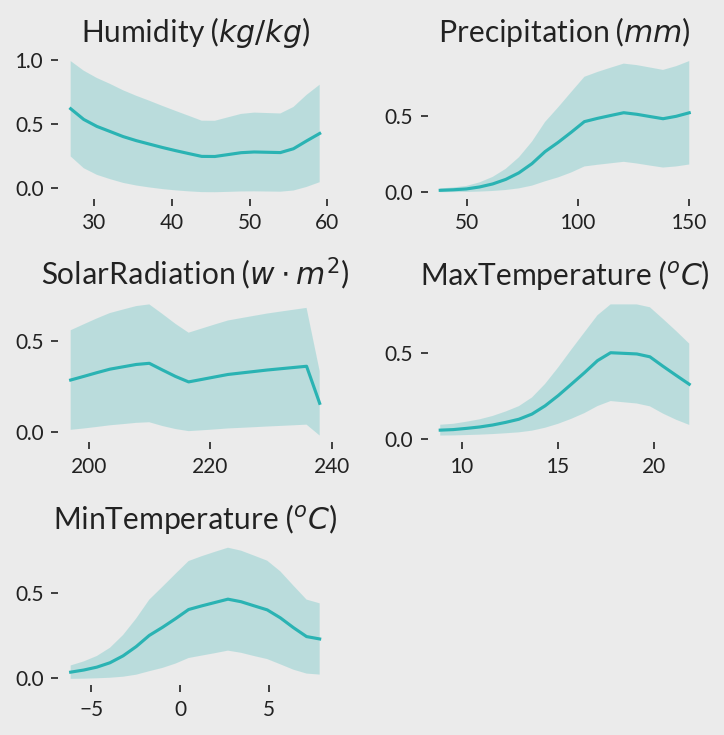

In [22]:
# partial dependence plot
labels = ['Humidity', 'Precipitation', 'SolarRadiation', 'MaxTemperature', 'MinTemperature']
units = ['$kg/kg$', '$mm$', '$w \cdot m^2$', '$^oC$', '$^oC$']
plot_labels = [f"{label} ({unit})" for label, unit in zip(labels, units)]
fig, ax = model.partial_dependence_plot(xtest, n_bins=20, labels=plot_labels, dpi=150)
fig.savefig(join(plots, 'ecoregion-mode-partial-dependence.png'), dpi=200)

## Section 5: Model ensembles

### 5.1 Ecoregion-wide models

In [9]:
# apply the model predictions
rerun = True

current_mean_path = join(models, f"ecoregion_model_current_mean.tif")
rcp45_mean_path = join(models, f"ecoregion_model_rcp45_mean.tif")
rcp85_mean_path = join(models, f"ecoregion_model_rcp85_mean.tif")
current_stdv_path = join(models, f"ecoregion_model_current_stdv.tif")
rcp45_stdv_path = join(models, f"ecoregion_model_rcp45_stdv.tif")
rcp85_stdv_path = join(models, f"ecoregion_model_rcp85_stdv.tif")
rcp45_change_path = join(models, "ecoregion_model_rcp45_change.tif")
rcp85_change_path = join(models, "ecoregion_model_rcp85_change.tif")

if rerun:
    current_preds = []
    rcp45_preds = []
    rcp85_preds = []

    for fold, model in enumerate(ecoregion_models):

        current_raster = join(models, f"ecoregion_model_current_{fold}.tif")
        rcp45_raster = join(models, f"ecoregion_model_rcp45_{fold}.tif")
        rcp85_raster = join(models, f"ecoregion_model_rcp85_{fold}.tif")

        ela.apply_model_to_rasters(model, climate2006, current_raster, quiet=True)
        ela.apply_model_to_rasters(model, climatercp45, rcp45_raster, quiet=True)
        ela.apply_model_to_rasters(model, climatercp85, rcp85_raster, quiet=True)
        
        # read the data into memory
        with rio.open(current_raster, 'r') as c, rio.open(rcp45_raster, 'r') as r45, rio.open(rcp85_raster, 'r') as r85:
            current_preds.append(c.read(1, masked=True))
            rcp45_preds.append(r45.read(1, masked=True))
            rcp85_preds.append(r85.read(1, masked=True))
            profile = c.profile.copy()
        
    # ensemble the results
    current_stack = np.stack(current_preds)
    rcp45_stack = np.stack(rcp45_preds)
    rcp85_stack = np.stack(rcp85_preds)
    
    # first the mean
    current_mean = current_stack.mean(axis=0)
    rcp45_mean = rcp45_stack.mean(axis=0)
    rcp85_mean = rcp85_stack.mean(axis=0)
    
    with rio.open(current_mean_path, 'w', **profile) as c, rio.open(rcp45_mean_path, 'w', **profile) as r45, rio.open(rcp85_mean_path, 'w', **profile) as r85:
        c.write(current_mean, 1)
        r45.write(rcp45_mean, 1)
        r85.write(rcp85_mean, 1)
    
    # then the standard deviation
    current_stdv = current_stack.std(axis=0)
    rcp45_stdv = rcp45_stack.std(axis=0)
    rcp85_stdv = rcp85_stack.std(axis=0)

    with rio.open(current_stdv_path, 'w', **profile) as c, rio.open(rcp45_stdv_path, 'w', **profile) as r45, rio.open(rcp85_stdv_path, 'w', **profile) as r85:
        c.write(current_stdv, 1)
        r45.write(rcp45_stdv, 1)
        r85.write(rcp85_stdv, 1)
        
    # then compute the change between climate scenarios
    rcp45_change = rcp45_mean - current_mean
    rcp85_change = rcp85_mean - current_mean
        
    with rio.open(rcp45_change_path, 'w', **profile) as r45, rio.open(rcp85_change_path, 'w', **profile) as r85:
        r45.write(rcp45_change, 1)
        r85.write(rcp85_change, 1)

# Plotting and visualization

### Shifts in big tree suitability

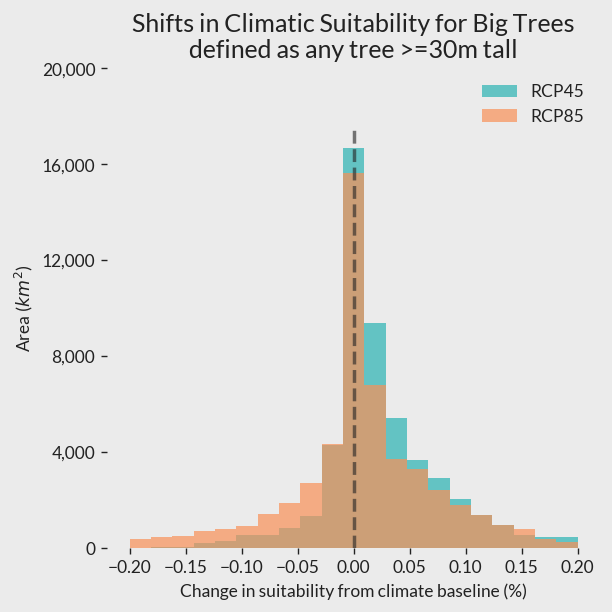

In [25]:
ecoregion = gpd.read_file(sierra)
poly = ecoregion.iloc[0].geometry
with rio.open(rcp45_change_path, 'r') as r45, rio.open(rcp85_change_path, 'r',) as r85:
    c45 = ela.geo.read_raster_from_polygon(r45, poly)
    c85 = ela.geo.read_raster_from_polygon(r85, poly)
    c45 = c45[c45.mask == False]
    c85 = c85[c85.mask == False]

rng = (-0.2, 0.2)
bins = 21

plt.hist(c45, bins=bins, range=rng, label='RCP45', alpha=0.7)
plt.hist(c85, bins=bins, range=rng, label='RCP85', alpha=0.7)
ylim = plt.ylim()
plt.plot((0,0), ylim, linestyle='--', linewidth=2, color='#222222', alpha=0.6)

# convert pixel counts to km2
area_scaler = 4 # 2x2 km pixels
pos, labels = plt.yticks()
km2 = pos * area_scaler
area_labels = [f"{km:,}" for km in km2.astype(np.int16)]
plt.yticks(pos, area_labels)

plt.xlabel("Change in suitability from climate baseline (%)")
plt.ylabel("Area ($km^2$)")
plt.title(f"Shifts in Climatic Suitability for Big Trees\ndefined as any tree >={big_thresh}m tall")
plt.legend()
plt.tight_layout()

outfile = join(plots, "climate-suitability-change-ecoregion.png")
plt.savefig(outfile, dpi=300)

### Plotting frequency distributions for climate variables

In [ ]:
is_big = (sampled['canopyHeight'] >= big_thresh).to_numpy()
humid = sampled['humid'].to_numpy() / 10000
ppt = sampled['ppt'].to_numpy()
rad = sampled['rad'].to_numpy()
tmin = sampled['tmin'].to_numpy()
tmax = sampled['tmax'].to_numpy()

cvars = [humid, ppt, rad, tmin, tmax]
labels = ['Humidity', 'Precipitation', 'SolarRadiation', 'MinTemperature', 'MaxTemperature']
units = ['$kg/kg$', '$mm$', '$w \cdot m^2$', '$^oC$', '$^oC$']

for cvar, label, unit in zip(cvars, labels, units):
    xmin = np.percentile(cvar, 1)
    xmax = np.percentile(cvar, 99)
    bins = 12

    plt.hist(cvar[~is_big], bins=bins, range=(xmin, xmax), label="All trees", color='orange', alpha=0.6, density=True)
    plt.hist(cvar[is_big], bins=bins, range=(xmin, xmax), label="Big trees", color='green', alpha=0.4, density=True)

    plt.xlabel(f"{label} ({unit})")
    plt.ylabel("Normalized density")
    plt.title("Climatic Differences Between Populations")
    plt.legend()
    plt.tight_layout()
    
    outfile = join(plots, f'climate-distributions-{label}.png')
    plt.savefig(outfile, dpi=300)
    plt.close()